In [90]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision.models
import torchvision
from torch.utils.data import Dataset, DataLoader
#import transforms
from torchvision import transforms
from Data.IngredientsLoader import IngredientsDataset
import matplotlib.pyplot as plt
from CLIPyourFood.Data.utils import vec2lables
from CLIPyourFood.model.ResNet import ResNet, model_urls
import time
import copy
import os
import clip

#choose random seed
seed = 42
np.random.seed(seed)

#depends on our vector of ingredients
num_classes = 227

In [ ]:
#defining the CLIP model
model, preprocess = clip.load("ViT-B/32", device=device)  #maybe change the model type of CLIP

In [ ]:
def get_clip_features(image, text):
	image = preprocess(image).unsqueeze(0).to(device)
	text = clip.tokenize(text).to(device)
	with torch.no_grad():
		image_features = model.encode_image(image)
		text_features = model.encode_text(text)
	return image_features, text_features

In [2]:
#hyperparameters
batch_size = 2
learning_rate = 1e-3
momentum=0.9
transforms = transforms.Compose(
[
    transforms.ToTensor(),
    transforms.Resize((224,224))
    #add normilization
])
#criterion of loss for multilabel classification
criterion = nn.BCEWithLogitsLoss()
use_cuda = False

In [ ]:
#load first time the dataset
# train_dataset = torchvision.datasets.Food101(dataset_path, split='train', download=True, transform=transforms)
# test_dataset = torchvision.datasets.Food101(dataset_path, split='test', download=True, transform=transforms)

In [3]:
# load the dataset

dataset_path = 'food101/train/food-101/images'
json_path = dataset_path + '/ing_jsn.json'

dataset = IngredientsDataset(json_path, dataset_path, transforms)

# split train and test
train_size = int(0.8 * dataset.__len__())
test_size = dataset.__len__() - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [4]:
def imshow(inp, title=None):
	"""
    Show tensor image with matplotlib
    :param inp: image tensor
    :param title: title of the image
    :return:
    """
	inp = inp.cpu() # if device else inp
	inp = inp.numpy().transpose((1, 2, 0))

	# mean = np.array([0.485, 0.456, 0.406])
	# std = np.array([0.229, 0.224, 0.225])
	# inp = std * inp + mean
	# inp = np.clip(inp, 0, 1)

	plt.imshow(inp)
	if title is not None:
		plt.title(title)
	# plt.pause(0.001)

In [5]:
images, ing_list = next(iter(train_dataloader))

In [6]:
vec2lables(ing_list[1], os.path.join(dataset_path+'/ing_vector_one_in_line.txt'))

['butter',
 'flour',
 'nut',
 'salt',
 'bread',
 'pepper',
 'egg',
 'dijon mustard',
 'milk',
 'bacon',
 'cheese',
 'thyme']

torch.Size([3, 224, 224])

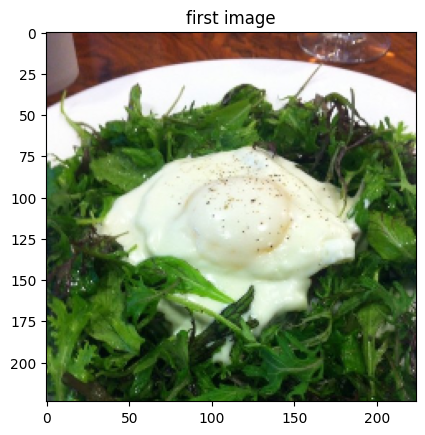

In [7]:
#see an example of the dataset
imshow(images[1,:,:,:], title='first image')
images[1,:,:,:].shape

In [91]:
#model
# net = models.resnet18(pretrained=True)
net = ResNet(depth=18)#,num_classes=num_classes)
# net = torchvision.models.get_model_weights(torchvision.models.resnet18)
net.load_state_dict(torch.hub.load_state_dict_from_url(model_urls['resnet18']))
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)
#net = net.cuda() if device =='cuda:0'  else net
net


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [92]:
net_torch = torchvision.models.resnet18(pretrained=True)
print(net_torch.==net)

False


In [93]:
def compareModelWeights(model_a, model_b):
    module_a = model_a._modules
    module_b = model_b._modules
    if len(list(module_a.keys())) != len(list(module_b.keys())):
        return False
    a_modules_names = list(module_a.keys())
    b_modules_names = list(module_b.keys())
    for i in range(len(a_modules_names)):
        layer_name_a = a_modules_names[i]
        layer_name_b = b_modules_names[i]
        if layer_name_a != layer_name_b:
            return False
        layer_a = module_a[layer_name_a]
        layer_b = module_b[layer_name_b]
        if (
            (type(layer_a) == nn.Module) or (type(layer_b) == nn.Module) or
            (type(layer_a) == nn.Sequential) or (type(layer_b) == nn.Sequential)
            ):
            if not compareModelWeights(layer_a, layer_b):
                return False
        if hasattr(layer_a, 'weight') and hasattr(layer_b, 'weight'):
            if not torch.equal(layer_a.weight.data, layer_b.weight.data):
                return False
    return True

In [ ]:
compareModelWeights(net, net_torch)

In [56]:
#edit the final layer of the model
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, num_classes)
net = net.cuda() if device =='cuda:0'  else net
net #check the model after the change

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [63]:
def predict(outputs, threshold=0.5):
    """
    :param outputs: output of the model
    :return: the predicted labels
    """
    predicted = torch.sigmoid(outputs)
    predicted[predicted >= threshold] = 1
    predicted[predicted < threshold] = 0
    return predicted

In [64]:
#evaluation of model on test set
def evaluate_model(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        preds = predict(outputs, threshold=0.8)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss /  (len(dataloader.dataset) * preds.shape[1]) #preds.nelement()
    epoch_acc = running_corrects.double() /  (len(dataloader.dataset) * preds.shape[1])
    return epoch_loss, epoch_acc

epoch_loss, epoch_acc = evaluate_model(net, test_dataloader, criterion)

KeyboardInterrupt: 

In [66]:
n_epochs = 5
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()

        outputs = net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pred = predict(outputs, threshold=0.8)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if batch_idx % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in test_dataloader:
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            #_,pred_t = torch.max(outputs_t, dim=1)
            pred_t = predict(outputs_t, threshold=0.8)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/(len(test_dataloader) * pred_t.shape[1]))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')


        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'resnet.pt')
            print('Improvement-Detected, save-model')
    net.train()

Epoch 1

Epoch [1/5], Step [0/27270], Loss: 0.7694
Epoch [1/5], Step [20/27270], Loss: 0.6738
Epoch [1/5], Step [40/27270], Loss: 0.6332
Epoch [1/5], Step [60/27270], Loss: 0.5974
Epoch [1/5], Step [80/27270], Loss: 0.5064
Epoch [1/5], Step [100/27270], Loss: 0.4164
Epoch [1/5], Step [120/27270], Loss: 0.3171
Epoch [1/5], Step [140/27270], Loss: 0.3157
Epoch [1/5], Step [160/27270], Loss: 0.1852
Epoch [1/5], Step [180/27270], Loss: 0.1281
Epoch [1/5], Step [200/27270], Loss: 0.3086
Epoch [1/5], Step [220/27270], Loss: 0.1735
Epoch [1/5], Step [240/27270], Loss: 0.2375
Epoch [1/5], Step [260/27270], Loss: 0.1178
Epoch [1/5], Step [280/27270], Loss: 0.2043
Epoch [1/5], Step [300/27270], Loss: 0.2181
Epoch [1/5], Step [320/27270], Loss: 0.2068
Epoch [1/5], Step [340/27270], Loss: 0.1727
Epoch [1/5], Step [360/27270], Loss: 0.2731
Epoch [1/5], Step [380/27270], Loss: 0.1099
Epoch [1/5], Step [400/27270], Loss: 0.1065
Epoch [1/5], Step [420/27270], Loss: 0.2104
Epoch [1/5], Step [440/27270]

KeyboardInterrupt: 

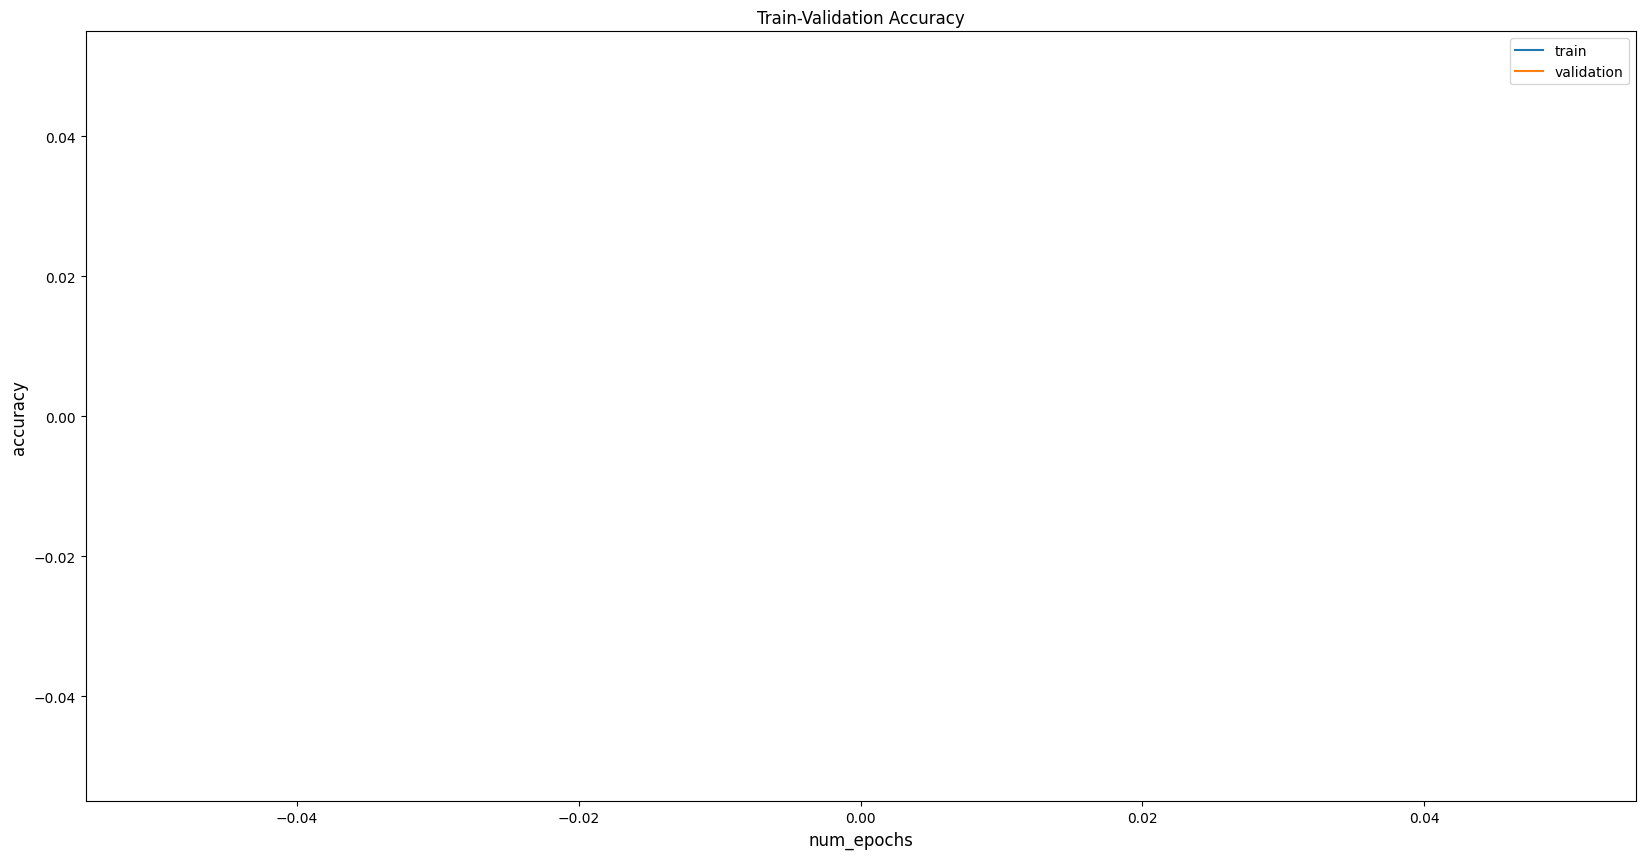

In [67]:
#plot statistics
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

AttributeError: 'Subset' object has no attribute 'classes'

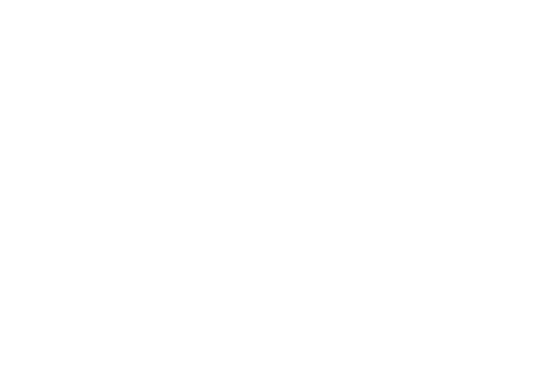

In [18]:
#visualize the model
def visualize_model(net, num_images=4):
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))

    for i, data in enumerate(test_dataloader):
        inputs, labels = data
        if use_cuda:
            inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(inputs)
        _, preds = torch.max(outputs.data, 1)
        preds = preds.cpu().numpy() if use_cuda else preds.numpy()
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(2, num_images//2, images_so_far)
            ax.axis('off')
            ax.set_title('predictes: {}'.format(test_dataset.classes[preds[j]]))
            imshow(inputs[j])

            if images_so_far == num_images:
                return

plt.ion()
visualize_model(net)
plt.ioff()